In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Setup
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
env_path = project_root / 'config' / '.env'
load_dotenv(env_path)

from src.database import DatabaseConnection
from src.modeling.feature_engineering import FeatureEngineer
from src.modeling.train_models import ModelTrainer

# Load data
db = DatabaseConnection()
df = pd.read_sql("SELECT * FROM hospital_readmissions_transformed", db.engine)

In [2]:
fe = FeatureEngineer(df)
X, y = fe.prepare_features()

Preparing features for modeling...

Feature Matrix Shape: (25000, 52)
Target Shape: (25000,)
Target Distribution:
  - Class 0 (Not Readmitted): 13246 (52.98%)
  - Class 1 (Readmitted): 11754 (47.02%)

Numeric Features: 16
Categorical Features: 9

One-hot encoding 9 categorical features...
  Encoded. New shape: (25000, 81)

Removing low-variance features...
  Removed -42 low-variance features
  Kept 123 features


In [3]:
# Train/test split
trainer = ModelTrainer(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = trainer.train_test_split()


CREATING TRAIN/TEST SPLIT

Train Set:
  - Samples: 17500
  - Class 0: 9272 (52.98%)
  - Class 1: 8228 (47.02%)

Test Set:
  - Samples: 7500
  - Class 0: 3974 (52.99%)
  - Class 1: 3526 (47.01%)


In [4]:

# Scale features
X_train_scaled, X_test_scaled = fe.scale_numeric_features(X_train, X_test)


Scaling numeric features...
  Scaled 16 numeric features


In [5]:
# Train all models
trainer.train_all_models(X_train_scaled, y_train)


TRAINING ALL MODELS

--------------------------------------------------------------------------------
TRAINING: Logistic Regression
--------------------------------------------------------------------------------
✓ Model trained successfully

--------------------------------------------------------------------------------
TRAINING: Random Forest
--------------------------------------------------------------------------------
✓ Model trained successfully

--------------------------------------------------------------------------------
TRAINING: Gradient Boosting
--------------------------------------------------------------------------------
✓ Model trained successfully


In [6]:
# Evaluate
trainer.evaluate_models(X_test_scaled, y_test)


MODEL EVALUATION

Logistic Regression:
----------------------------------------
  Accuracy:  0.6129
  Precision: 0.6212
  Recall:    0.4529
  F1 Score:  0.5239
  ROC AUC:   0.6463

  Confusion Matrix:
    True Negative:  3000
    False Positive: 974
    False Negative: 1929
    True Positive:  1597

Random Forest:
----------------------------------------
  Accuracy:  0.6108
  Precision: 0.5895
  Recall:    0.5669
  F1 Score:  0.5780
  ROC AUC:   0.6513

  Confusion Matrix:
    True Negative:  2582
    False Positive: 1392
    False Negative: 1527
    True Positive:  1999

Gradient Boosting:
----------------------------------------
  Accuracy:  0.6148
  Precision: 0.6040
  Recall:    0.5247
  F1 Score:  0.5615
  ROC AUC:   0.6529

  Confusion Matrix:
    True Negative:  2761
    False Positive: 1213
    False Negative: 1676
    True Positive:  1850


In [7]:
# Display results
print("\n" + "="*80)
print("DETAILED MODEL EVALUATION")
print("="*80)

results_df = trainer.get_results_summary()
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))


DETAILED MODEL EVALUATION

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1 Score  ROC AUC
Logistic Regression  0.612933   0.621159 0.452921  0.523864 0.646272
      Random Forest  0.610800   0.589502 0.566931  0.577996 0.651267
  Gradient Boosting  0.614800   0.603983 0.524674  0.561542 0.652864


In [9]:
 # Feature importance for Random Forest
print("\n\nRandom Forest - Top 10 Important Features:")
rf_model = trainer.models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))



Random Forest - Top 10 Important Features:
              feature  importance
total_previous_visits    0.090357
          n_inpatient    0.082420
     n_lab_procedures    0.079397
        n_medications    0.071218
has_inpatient_history    0.053380
     time_in_hospital    0.049551
          age_numeric    0.033388
         n_procedures    0.032787
         n_outpatient    0.026494
          n_emergency    0.021338


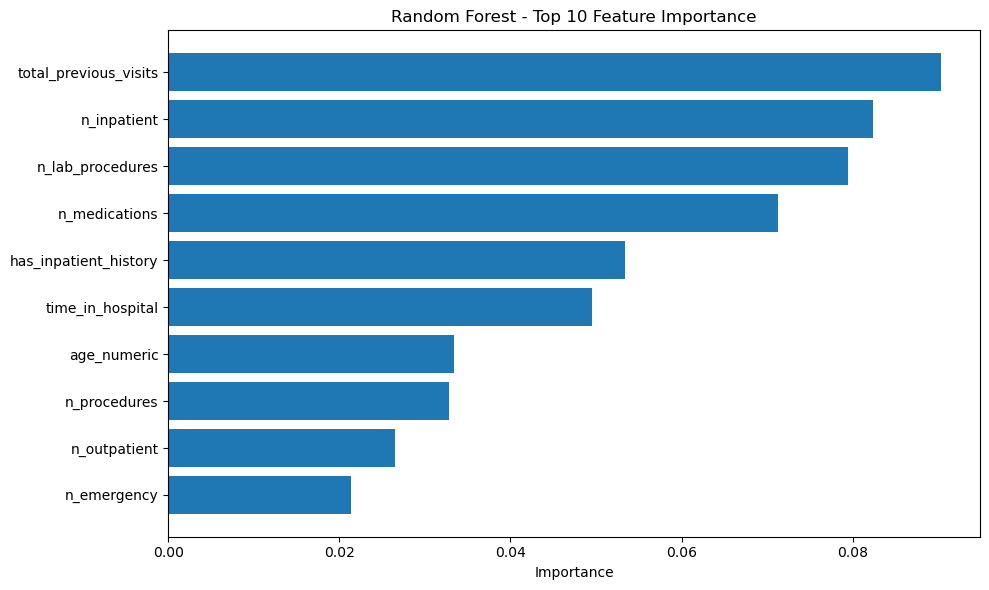

In [10]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['importance'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance')
ax.set_title('Random Forest - Top 10 Feature Importance')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Select best model
best_model_name = trainer.select_best_model(metric='f1')
trainer.save_best_model(output_dir='../output')

print("\n✓ Model evaluation complete!")


MODEL SELECTION

Selecting best model based on F1:

  Logistic Regression: 0.5239
  Random Forest: 0.5780
  Gradient Boosting: 0.5615

✓ Best Model: Random Forest (f1=0.5780)

SAVING MODEL
✓ Model saved to: ../output/best_model_random_forest.pkl
✓ Metadata saved to: ../output/model_metadata_random_forest.json

✓ Model evaluation complete!
